In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')
import numpy as np
from PIL import Image

# Project Introduction
## 开发环境及系统运行要求
这次的项目对于性能没有要求，另外老师也提供了Matlab代码，因为自己也对Matlab比较熟悉，所以本来想使用Matlab来写，但是因为要求使用Python，我还是使用了Python。
## 工作分配简介
在这个项目当中，代码以及实验都由我自己完成。
# Technical Details
我们有一张图片`corr_img`, 我们需要从中恢复出原来的图片`img`。在老师提供的代码当中，是使用逐行回归来实现图像回复的。对于按行回归的方法来说，可以想象某一行图像的某一个通道是一个关于x坐标的函数，我们需要做的就是从当前看的到的像素点当中来得出其他位置的像素。
## 线性模型
具体来说，我们希望拟合这样的一个函数
$$y(\mathbf{x}, \mathbf{w}) = \sum_{i=0}^{M-1}w_i \phi_i(\mathbf{x}) = \mathbf{w}^\top \mathbf{\phi}(\mathbf{x})$$
这里的基函数$\phi_i(\mathbf{x})$可以选取多种，比如高斯函数
$$\phi_i(x) = \exp \{ - \frac{(x - \mu_i)^2}{2 \sigma_i^2}\}$$

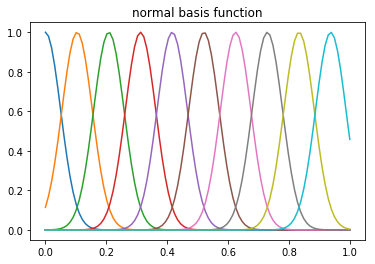

In [2]:
def normal_pdf(x, mu, sigma):
    return np.exp(- np.power((x - mu), 2) / (2 * np.power(sigma, 2)))
basis_num = 50
mu = np.linspace(0, 1, basis_num - 1)
x = np.linspace(0, 1, 100)
sigma = 0.05
for i in range(0, basis_num - 1, 5):
    plt.plot(x, normal_pdf(x, mu[i], sigma))
plt.title('normal basis function');

或者sigmoid函数

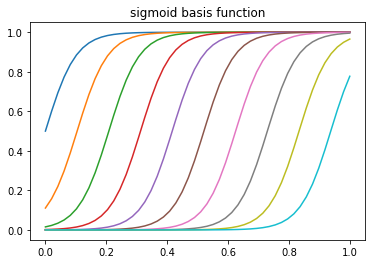

In [3]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
basis_num = 50
mu = np.linspace(0, 1, basis_num - 1)
x = np.linspace(0, 1, basis_num)
s = 0.05
for i in range(0, basis_num - 1, 5):
    plt.plot(x, sigmoid((x - mu[i]) / s))
plt.title('sigmoid basis function');

我们可以使用最小二乘法来解$\mathbf{x}$
$$\mathbf{w}_{\text{ML}} = (\mathbf{\Phi}^\top \mathbf{\Phi})^{-1} \mathbf{\Phi}^\top \mathbf{y}$$
然后我们再使用对应的$\mathbf{w}_{\text{ML}}$ 进行预测就可以了。也就是说，对于一个新的预测点，我们将其$x$坐标带入，对应的预测就是
$$y = \mathbf{w}_{\text{ML}} \mathbf{\phi}(x)$$
在这种做法当中，我们可以认为，我们使用函数族$y = \mathbf{w}^\top \phi(\mathbf{x})$ 来进行一行元素的插值。
## K近邻回归
上面所说的线性模型当中，每次只考虑一个通道当中的一行图像像素，这样会只关注图像当中的一行信息，可能会导致一些连续两行之间的预测不统一，导致一些不自然的现象。K近邻回归对于每个待填充的点，找到附近的$K$个点，并且对其进行加权平均，为当前这个点做出预测。
## pix2pix模型
线性模型和K近领回归也都关注的是局部的信息，而且只使用单张图像来进行对图像进行恢复，因此产生出来的图像只关注于局部信息，而不关注全局信息,而且也不能捕捉到自然图像的统计信息。pix2pix是一种图像与图像之间转换的框架，其基于卷积神经网络，可以建模图片A和图片B的映射。在我们的应用当中，图片A是被损坏的图片，图片B是原来的图片。
(pix2pix模型示意图)
在pix2pix模型当中，每次输入一张图片，我们的生成器就会生成一张图片，并且交给判别器，帮助生成器生成的图片更加接近真实图片的分布。
(pix2pix生成器两种结构Unet, Resnet 示意图)

# Experiment Results
我们首先展示各个模型的结果，最后进行各个模型的数值上结果的比较。

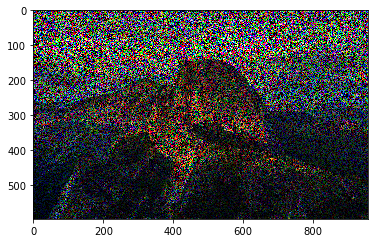

In [4]:
# show image
img = np.array(Image.open('./data/1_C.png')) / 255.0
plt.imshow(img);

## 按行线性回归

In [5]:
from row_regression import normal_phi, sigmoid_phi, regression_by_row

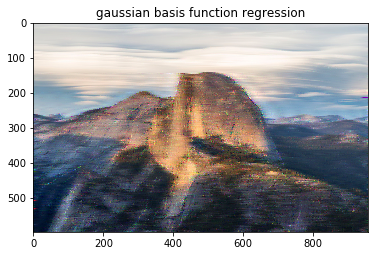

In [6]:
res_img = regression_by_row(img, normal_phi)
plt.imshow(res_img)
plt.title('gaussian basis function regression');

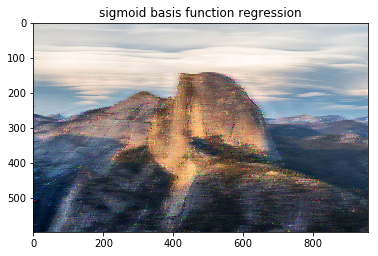

In [7]:
res_img = regression_by_row(img, sigmoid_phi)
plt.imshow(res_img)
plt.title('sigmoid basis function regression');

## 使用k近邻回归

In [8]:
from knn_regression import knn_regression

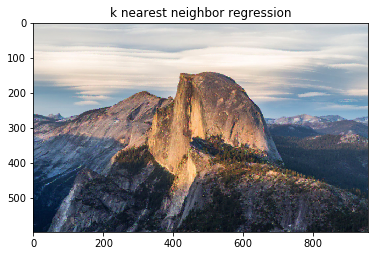

In [9]:
res_img = knn_regression(img, n_neighbors = 7, weights='distance')
plt.imshow(res_img)
plt.title('k nearest neighbor regression');

## Pix2Pix 
我使用了pix2pix框架，搜集了1000余张图片，构建起训练样本，然后进行训练。因为时间有限，没有对程序的性能进行详尽的调优，只使用了一些默认设置。可能是因为测试的数据和训练的数据不在同一个分布上，所以说测试的效果比较差。

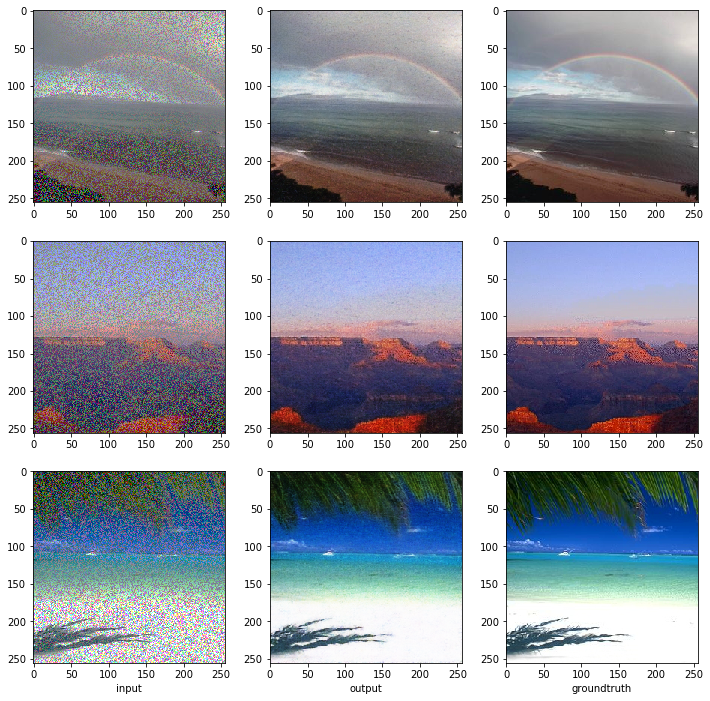

In [10]:
cnn_img_names = ['epoch198', 'epoch199', 'epoch200']
f, axarr = plt.subplots(3, 3, figsize=(12, 12))

for i, img_name in enumerate(cnn_img_names):
    in_img = Image.open('./CNN-results/' + img_name + "_real_A.png")
    out_img = Image.open('./CNN-results/' + img_name + "_fake_B.png")
    gt = Image.open('./CNN-results/' + img_name + "_real_B.png")
    axarr[i, 0].imshow(in_img)
    axarr[i, 1].imshow(out_img)
    axarr[i, 2].imshow(gt)
axarr[2, 0].set_xlabel('input')
axarr[2, 1].set_xlabel('output')
axarr[2, 2].set_xlabel('groundtruth');

我们可以看到，效果还是很不错的，但是如果将这个算法应用到测试的图片上，效果就比较差了，得到的图片整体的颜色都有了很大的变动。

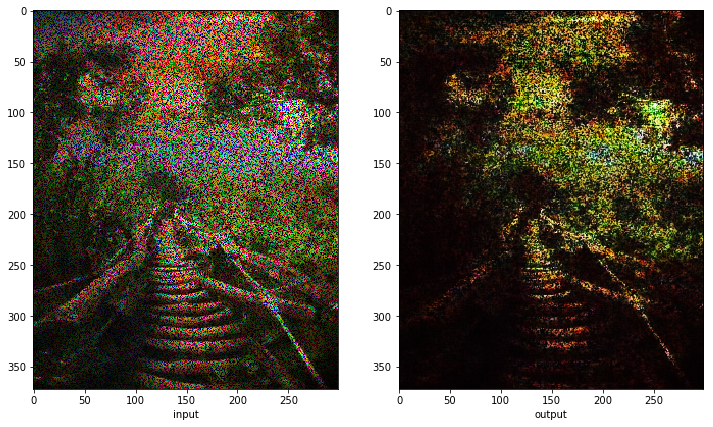

In [11]:
f, axarr = plt.subplots(1, 2, figsize=(12, 12))
in_img = Image.open('./CNN-results/B.png')
out_img = Image.open('./CNN-results/B_fake.png')
axarr[0].imshow(in_img)
axarr[1].imshow(out_img)
axarr[0].set_xlabel('input')
axarr[1].set_xlabel('output');

## 数值结果比较
因为从图像当中，我们就可以看出pix2pix的效果并不好，所以接下来，我们侧重于，按行回归与k近邻回归的比较

In [12]:
def img_dist(img1, img2):
    # average 2-norm error
    return np.sum(np.power(img1 - img2, 2)) / np.prod(img1.shape)
def np_img(s):
    return np.array(Image.open(s).convert("RGB")) / 255.0

In [13]:
results = dict()
results["gaussian"] = []
results["sigmoid"] = []
results["knn"] = []

# we will use 3 images and 3 noise level and get the average
for i in range(1, 4):
    ori_img = np_img('./data/' + str(i) + "_ori.png")
    for t in ["A", "B", "C"]:
        corr_img = np_img('./data/' + str(i) + "_" + t + ".png")
        # three methods
        # gaussian basis function
        res_img = regression_by_row(corr_img, normal_phi)
        results["gaussian"].append(img_dist(res_img, ori_img))
        # sigmoid basis function
        res_img = regression_by_row(corr_img, sigmoid_phi)
        results["sigmoid"].append(img_dist(res_img, ori_img))
        # knn regression
        res_img = knn_regression(corr_img)
        results["knn"].append(img_dist(res_img, ori_img))

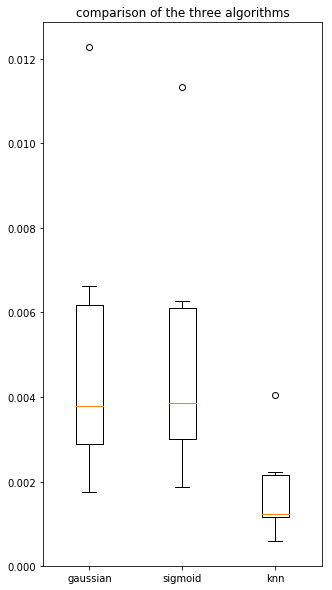

In [14]:
data = [results["gaussian"], results["sigmoid"], results["knn"]]
fig = plt.figure(1, figsize=(5, 10))
ax = fig.add_subplot(111)
bp = ax.boxplot(data)
plt.xticks([1, 2, 3], ['gaussian', 'sigmoid', 'knn'])
plt.title('comparison of the three algorithms')

我们可以看到使用一些默认的设置，KNN回归的效果明显是最好的，接着，我们来调整KNN回归的超参数来得到一个最后的模型，并且对我们的测试图像进行预测。我们使用更多的测试图片，对性能进行进一步的调优。我们找到16张自然风光的图片，并且通过这些图片确定比较好的参数，并且做出最后的预测。

In [15]:
def img_dist(img1, img2):
    # 2-norm error
    return np.sum(np.power(img1 - img2, 2))
def np_img(s, mode):
    return np.array(Image.open(s).convert(mode))

In [16]:
# choose a setting
from utils import corrupt_img
from os import listdir
from os.path import isfile, join
img_path = './test-data/origin'
img_list = [f for f in listdir(img_path) if isfile(join(img_path, f))]
img_list = ['B.png']
corr_mode = 'B'

neighbors_list = [i for i in range(1, 15)]
cv_results = {}
for n in neighbors_list:
    cv_results[n] = []

for img_name in img_list:
    if corr_mode == 'A':
        img = np_img(join(img_path, img_name), 'L')
        img = img[:, :, np.newaxis]
    else:
        img = np_img(join(img_path, img_name), 'RGB')
    # corrupt image
    for i in range(10):
        # repeat 10 times
        corr_img = corrupt_img(img, corr_mode)
        for n_neighbors in neighbors_list:
            res_img = knn_regression(corr_img, n_neighbors=n_neighbors, weights='distance')
            cv_results[n_neighbors].append(img_dist(res_img, img))    

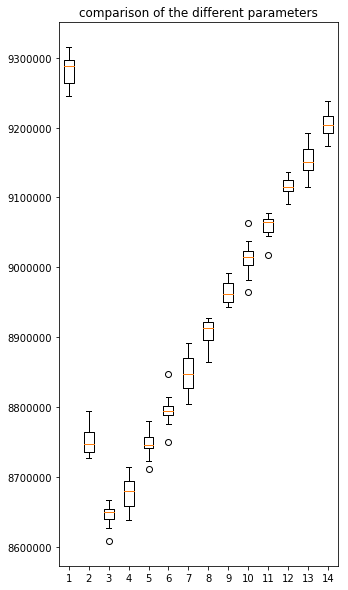

In [17]:
data = [cv_results[i] for i in range(1, 15)]
fig = plt.figure(1, figsize=(5, 10))
ax = fig.add_subplot(111)
bp = ax.boxplot(data)
plt.xticks([i for i in range(1, 15)], [i for i in range(1, 15)])
plt.title('comparison of the different parameters')

我们可以从下面的图看到对于这几张测试图片，`n_neighbors=3`的时候，准确率最高，于是我就选用`n_neighbors=3`得到的分类器作为最后的输出。

# 结果
最后，我们对测试图片进行预测并且输出。

In [19]:
corr_img = np_img('./test-data/A.png', 'L')
corr_img = np.expand_dims(corr_img, 2)
res_img = knn_regression(corr_img, n_neighbors=3, weights='distance')
res_img = res_img.squeeze(2)
Image.fromarray(res_img).save('./test-data/res_A.png')
corr_img = np_img('./test-data/B.png', 'RGB')
res_img = knn_regression(corr_img, n_neighbors=3, weights='distance')
Image.fromarray(res_img).save('./test-data/res_B.png')
corr_img = np_img('./test-data/C.png', 'RGB')
res_img = knn_regression(corr_img, n_neighbors=2, weights='distance')
Image.fromarray(res_img).save('./test-data/res_C.png')